In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def optical_flow(old_frame, new_frame, window_size=5, min_quality=0.01):
    max_corners = 1000
    min_distance = 1
    feature_list = cv2.goodFeaturesToTrack(old_frame, max_corners, min_quality, min_distance)

    w = window_size // 2

    old_frame = old_frame / 255.0
    new_frame = new_frame / 255.0

    kernel_x = np.array([[-1, 1], [-1, 1]])
    kernel_y = np.array([[-1, -1], [1, 1]])
    kernel_t = np.array([[1, 1], [1, 1]])

    fx = cv2.filter2D(old_frame, -1, kernel_x)
    fy = cv2.filter2D(old_frame, -1, kernel_y)
    ft = cv2.filter2D(new_frame, -1, kernel_t) - cv2.filter2D(old_frame, -1, kernel_t)

    u = np.zeros(old_frame.shape)
    v = np.zeros(old_frame.shape)

    for feature in feature_list:
        j, i = feature.ravel()
        i, j = int(i), int(j)

        if i - w < 0 or i + w + 1 > old_frame.shape[0] or j - w < 0 or j + w + 1 > old_frame.shape[1]:
            continue

        I_x = fx[i-w:i+w+1, j-w:j+w+1].flatten()
        I_y = fy[i-w:i+w+1, j-w:j+w+1].flatten()
        I_t = ft[i-w:i+w+1, j-w:j+w+1].flatten()

        b = np.reshape(I_t, (I_t.shape[0], 1))
        A = np.vstack((I_x, I_y)).T

        if A.shape[0] > 1:
            U = np.matmul(np.linalg.pinv(A), b)
            u[i, j] = U[0][0]
            v[i, j] = U[1][0]

    return feature_list, u, v


def draw_flow(img, features, u, v, scale=5):
    img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    for pt in features:
        x, y = pt.ravel()
        x, y = int(x), int(y)
        dx = int(u[y, x] * scale)
        dy = int(v[y, x] * scale)
        cv2.arrowedLine(img_color, (x, y), (x+dx, y+dy), (0, 255, 0), 1, tipLength=0.3)
    return img_color


def process_images(image1_path, image2_path):
    old_frame = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)
    new_frame = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)

    features, u, v = optical_flow(old_frame, new_frame)
    flow_img = draw_flow(new_frame, features, u, v)

    plt.imshow(cv2.cvtColor(flow_img, cv2.COLOR_BGR2RGB))
    plt.title("Optical Flow")
    plt.axis("off")
    plt.show()


def process_video(video_path):
    cap = cv2.VideoCapture(video_path)
    ret, old_frame = cap.read()

    if not ret:
        print("Cannot read video.")
        return

    old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        new_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        features, u, v = optical_flow(old_gray, new_gray)
        flow_img = draw_flow(new_gray, features, u, v)

        cv2.imshow("Optical Flow", flow_img)
        if cv2.waitKey(30) & 0xFF == 27:  # ESC to exit
            break
        old_gray = new_gray

    cap.release()
    cv2.destroyAllWindows()

In [2]:
process_video("track_Car.avi")

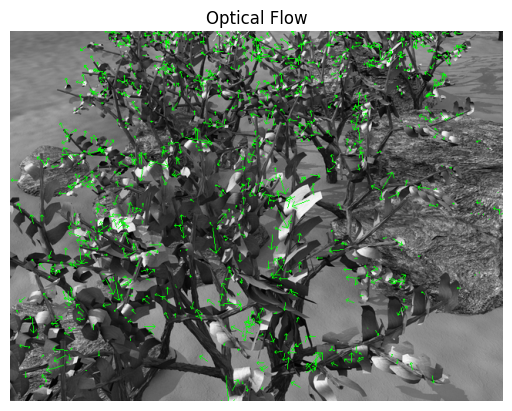

In [3]:
process_images("grove1.png", "grove2.png")

In [16]:
video_path="Cat.mp4" 
video = cv2.VideoCapture(video_path)

# read only the first frame for drawing a rectangle for the desired object
ret,frame = video.read()

# I am giving  big random numbers for x_min and y_min because if you initialize them as zeros whatever coordinate you go minimum will be zero 
x_min,y_min,x_max,y_max=36000,36000,0,0


def coordinat_chooser(event,x,y,flags,param):
    global go , x_min , y_min, x_max , y_max

    # when you click the right button, it will provide coordinates for variables
    if event==cv2.EVENT_RBUTTONDOWN:
        
        # if current coordinate of x lower than the x_min it will be new x_min , same rules apply for y_min 
        x_min=min(x,x_min) 
        y_min=min(y,y_min)

         # if current coordinate of x higher than the x_max it will be new x_max , same rules apply for y_max
        x_max=max(x,x_max)
        y_max=max(y,y_max)

        # draw rectangle
        cv2.rectangle(frame,(x_min,y_min),(x_max,y_max),(0,255,0),1)


    """
        if you didn't like your rectangle (maybe if you made some misclicks),  reset the coordinates with the middle button of your mouse
        if you press the middle button of your mouse coordinates will reset and you can give a new 2-point pair for your rectangle
    """
    if event==cv2.EVENT_MBUTTONDOWN:
        print("reset coordinate  data")
        x_min,y_min,x_max,y_max=36000,36000,0,0

cv2.namedWindow('coordinate_screen')
# Set mouse handler for the specified window, in this case, "coordinate_screen" window
cv2.setMouseCallback('coordinate_screen',coordinat_chooser)


while True:
    cv2.imshow("coordinate_screen",frame) # show only first frame 
    
    k = cv2.waitKey(5) & 0xFF # after drawing rectangle press ESC   
    if k == 27:
        cv2.destroyAllWindows()
        break


cv2.destroyAllWindows()

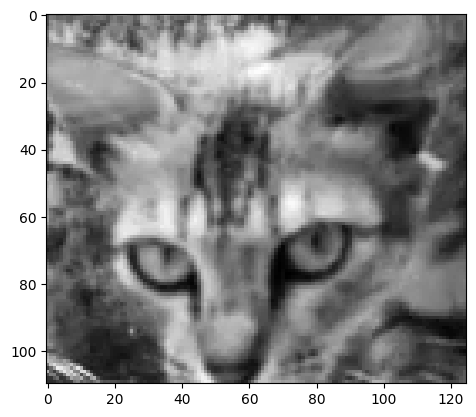

In [20]:
# take region of interest ( take inside of rectangle )
roi_image=frame[y_min:y_max,x_min:x_max]

# convert roi to grayscale
roi_gray=cv2.cvtColor(roi_image,cv2.COLOR_BGR2GRAY) 

# Params for corner detection
feature_params = dict(maxCorners=20,  # We want only one feature
                      qualityLevel=0.2,  # Quality threshold 
                      minDistance=7,  # Max distance between corners, not important in this case because we only use 1 corner
                      blockSize=7)

first_gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)

# Harris Corner detection
points = cv2.goodFeaturesToTrack(first_gray, mask=None, **feature_params)


# Filter the detected points to find one within the bounding box
for point in points:
    x, y = point.ravel()
    if y_min <= y <= y_max and x_min <= x <= x_max:
        selected_point = point
        break

# If a point is found, convert it to the correct shape
if selected_point is not None:
    p0 = np.array([selected_point], dtype=np.float32)

plt.imshow(roi_gray,cmap="gray")

In [22]:
############################ Parameters ####################################
import time
""" 
winSize --> size of the search window at each pyramid level
Smaller windows can more precisely track small, detailed features -->   slow or subtle movements and where fine detail tracking is crucial.
Larger windows is better for larger displacements between frames ,  more robust to noise and small variations in pixel intensity --> require more computations
"""

# Parameters for Lucas-Kanade optical flow
lk_params = dict(winSize=(7, 7),  # Window size
                 maxLevel=2,  # Number of pyramid levels
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))


############################ Algorithm ####################################
# Read video
cap = cv2.VideoCapture(video_path)

# Take first frame and find corners in it
ret, old_frame = cap.read()

width = old_frame.shape[1]
height = old_frame.shape[0]

# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)

frame_count = 0
start_time = time.time()

old_gray = first_gray

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    if p0 is not None:
        # Calculate optical flow
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)  
        good_new = p1[st == 1]  # st==1 means found point
        good_old = p0[st == 1]


        if len(good_new) > 0:
            # Calculate movement
            a, b = good_new[0].ravel()
            c, d = good_old[0].ravel()
 
            # Draw the tracks
            mask = cv2.line(mask, (int(a), int(b)), (int(c), int(d)), (0, 255, 0), 2)
            frame = cv2.circle(frame, (int(a), int(b)), 5, (0, 255, 0), -1)

            img = cv2.add(frame, mask)

            # Calculate and display FPS
            elapsed_time = time.time() - start_time
            fps = frame_count / elapsed_time if elapsed_time > 0 else 0
            cv2.putText(img, f"FPS: {fps:.2f}", (width - 200, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

            cv2.imshow('frame', img)

            # Update previous frame and points
            old_gray = frame_gray.copy()
            p0 = good_new.reshape(-1, 1, 2)

        else:
            p0 = None

        # Check if the tracked point is out of frame
        if not (25 <= a < width):
            p0 = None  # Reset p0 to None to detect new feature in the next iteration
            selected_point_distance = 0  # Reset selected point distance when new point is detected


    # Redetect features if necessary
    if p0 is None:
        p0 = cv2.goodFeaturesToTrack(frame_gray, mask=None, **feature_params)
        mask = np.zeros_like(frame)
        selected_point_distance=0
 
    frame_count += 1

    k = cv2.waitKey(25)
    if k == 27:
        break

 
cv2.destroyAllWindows()
cap.release()